# 프로젝트 개요

KNNRegressor과 RandomForestRegressor model을 사용하여 Apple의 historical data를 포함한 몇몇 feature들을 학습시켜, 실제 Apple의 주가를 예측해본다.

X=feature(today), y=closing price(tomorrow)

## Libraries Used

In [50]:
# Basics
import os
import random
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np

# Data downloading library
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Shallow learning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, TimeSeriesSplit

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Metrics
import sklearn.metrics as metrics

# Config

In [51]:
# import os
# import random
# import numpy as np
# import torch

def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

seed_everything(42) # Seed 고정

# Dataset

### Fixed
* Random seed:
    * Set to 42
    * See the seed_everything function under Config
* Scaling: StandardScaler
    * Scale train and test separatly
        * fit StandardScaler to the train data --> then use the same scaler to transform test data
    * Scale X, Don't scale y
    * Train
* Feature Engineering
    * Correlation heatmap --> check highly correlated features
        * maybe drop Adj Close? - yes!
* train-test split method
    * train - test split
    * (Later on...) train - gap - test split
* feature-target split
    * target: Closed_Tomorrow
    * feature: all - Closed_Torrow
* refs
    * https://docs.wandb.ai/guides/sweeps : hyperparms tuning




### Downloading data

In [376]:
# Download historical stock data of Apple (AAPL) using yfinance (yf) library
# DataFrame "last_update": 2003-08-05 ~ today (2023-08-06)
# 특이 Case로, APPl의 2023.06의 데이터부터 모델이 예측을 포기하는 현상이 발견된다.
# 다른 종목들에 대해서는, 이런 현상이 모두 나타나지 않는다.
# NVDA에서도 AAPL과 똑같은 현상
# MSFT 성능 그나마 제일 좋게 나옴

yesterday = datetime.now() - relativedelta(days=1)  # 어제 날짜
term = 20   # 기간 (years)

start = yesterday - relativedelta(years=term)
end = yesterday

last_update = yf.download('AAPL',
                    start = start,
                    end = end,
                    interval = "1d",
                    auto_adjust = True,
                    progress = False)

In [377]:
df = last_update.copy()
df

,Open,High,Low,Close,Volume
Date,,,,,
2003-08-11,0.300819,0.302489,0.296114,0.298390,137228000
2003-08-12,0.299908,0.300515,0.295355,0.298998,164438400
2003-08-13,0.301426,0.308711,0.297177,0.306283,284099200
2003-08-14,0.306739,0.308560,0.302640,0.303096,192780000
2003-08-15,0.303855,0.304614,0.298390,0.299149,125865600
...,...,...,...,...,...
2023-08-04,185.520004,187.380005,181.919998,181.990005,115799700
2023-08-07,182.130005,183.130005,177.350006,178.850006,97576100
2023-08-08,179.690002,180.270004,177.580002,179.800003,67823000


In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5035 entries, 2003-08-11 to 2023-08-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5035 non-null   float64
 1   High    5035 non-null   float64
 2   Low     5035 non-null   float64
 3   Close   5035 non-null   float64
 4   Volume  5035 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.0 KB


### Basic EDA

In [379]:
df.describe()

,Open,High,Low,Close,Volume
count,5035.000000,5035.000000,5035.000000,5035.000000,5.035000e+03
mean,37.890584,38.312862,37.484208,37.915060,4.111100e+08
std,49.637831,50.220289,49.096780,49.681768,3.946116e+08
min,0.298239,0.300515,0.292168,0.298390,3.145820e+07
25%,4.239696,4.293728,4.169880,4.240455,1.183631e+08
50%,17.331546,17.442643,17.155799,17.314104,2.782696e+08
75%,42.645031,43.325823,42.378472,42.587629,5.762904e+08
max,196.240005,198.229996,195.279999,196.449997,3.372970e+09


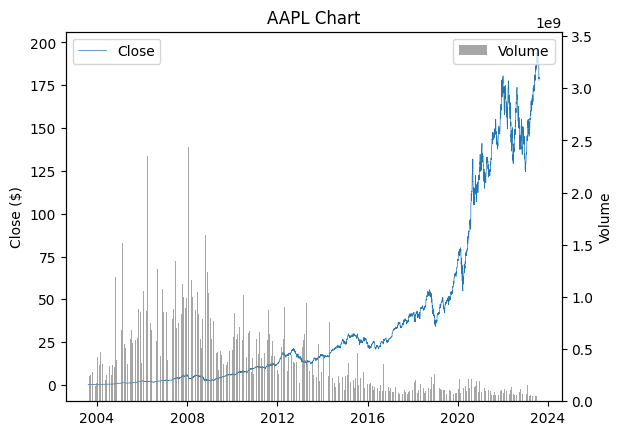

In [411]:
plt.plot(df.index, df["Close"], linewidth=0.5, label="Close")
plt.ylabel("Close ($)")
plt.legend(loc="upper left")

plt.twinx()
plt.bar(df.index, df["Volume"], color="gray", alpha=0.7, label="Volume")
plt.title("AAPL Chart")
plt.ylabel("Volume")
plt.legend(loc="upper right")
plt.show()

우상향 한다고 볼 수 있는 Chart, 비교적 최근 급하게 상승해 변동폭이 크다.

#### Correlations

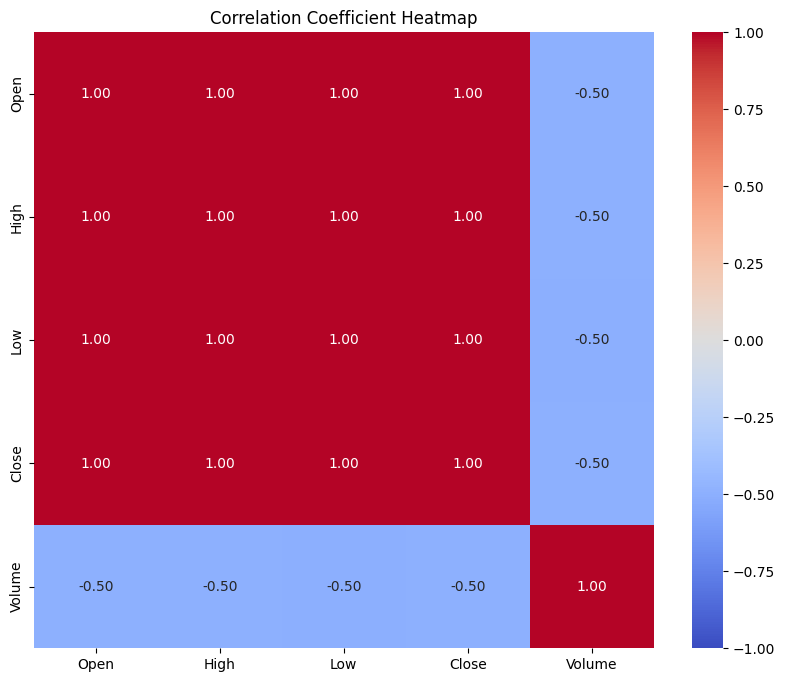

% of highly correlated pairs: 56.0 %


In [382]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,
            cmap='coolwarm',
            vmin=-1, vmax=1,
            fmt='.2f')

# Add a title to the heatmap
plt.title("Correlation Coefficient Heatmap")

# Show the plot
plt.show()

# Find pairs of columns with correlation coefficients >= 0.5 or <= -0.5
high_corr = 0
num_cols = len(df.columns)
for column1 in correlation_matrix.columns:
    for column2 in correlation_matrix.columns:
        if column1 != column2 and abs(correlation_matrix.loc[column1, column2]) >= 0.5:
            high_corr += 1
print(f"% of highly correlated pairs: {high_corr/(num_cols**2)*100:.1f} %")

Volume을 제외한 모든 column이 주가를 표현하기 때문에 Volume을 제외하고 모두 corellation이 크다.

#### Data distribution of each columns

<Axes: >

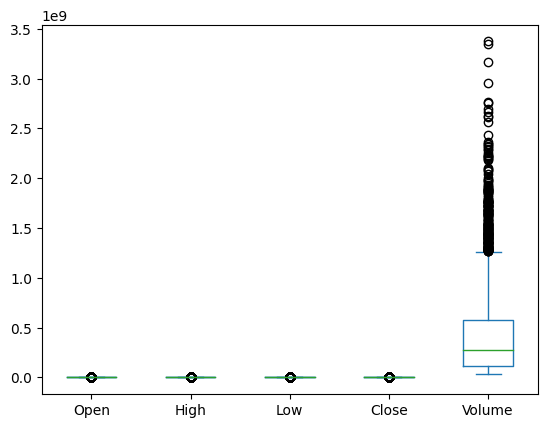

In [383]:
df.plot.box()

The range of the independent variable "Volume" is significantly wider than all the other variables.

--> Need to scale the data !

# Shallow Learning

* The effects of the number of records in the dataset
    * 1980 ~ (40 years)
    * 2003 ~ (20 years)
    * 2013 ~ (10 years)
* The effects of adding other relevant features
    * Dow futures
    * S&P500
    * S&P500
    * Nasdaq 100
    * Nasdaq futures
    * CBOE Volatility Index(뉴욕 주식시장 변동성 지수)
    * 미국 13주 만기 국채 이자율(Treasury interest rates(5W))
    * 미국 5년 만기 국채 이자율(Treasury interest rates(5Y))
    * 미국 10년 만기 국채 이자율(Treasury interest rates(10Y))
    * US dollar index(세계 주요 6개국 통화에 대비 미국 달러의 평균적인 가치를 나타내는 지표)
    * Crude Oil(원유 선물)

### Dataset

In [387]:
yesterday = datetime.now() - relativedelta(days=1)  # 어제 날짜
term = 20   # 기간 (years)

start = yesterday - relativedelta(years=term)
end = yesterday

last_update = yf.download('AAPL',
                    start = start,
                    end = yesterday,
                    interval = "1d",
                    auto_adjust = True,
                    progress = False)

In [388]:
df = last_update.copy()
df

,Open,High,Low,Close,Volume
Date,,,,,
2003-08-11,0.300819,0.302489,0.296114,0.298390,137228000
2003-08-12,0.299908,0.300515,0.295355,0.298998,164438400
2003-08-13,0.301426,0.308711,0.297177,0.306283,284099200
2003-08-14,0.306738,0.308560,0.302640,0.303096,192780000
2003-08-15,0.303855,0.304614,0.298390,0.299149,125865600
...,...,...,...,...,...
2023-08-04,185.520004,187.380005,181.919998,181.990005,115799700
2023-08-07,182.130005,183.130005,177.350006,178.850006,97576100
2023-08-08,179.690002,180.270004,177.580002,179.800003,67823000


"변동률" Column 추가

In [389]:
def create_label_column(df):
    # 'Close' 열을 기반으로 레이블 열 생성
    df['Up tomorrow'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    return df

df = create_label_column(df)

In [390]:
# 일 등락률 = (오늘종가 – 어제종가) / 어제종가 * 100

df["Change"] = df["Close"].pct_change() * 100
df = df.iloc[1:, :]
df

,Open,High,Low,Close,Volume,Up tomorrow,Change
Date,,,,,,,
2003-08-12,0.299908,0.300515,0.295355,0.298998,164438400,1,0.203659
2003-08-13,0.301426,0.308711,0.297177,0.306283,284099200,0,2.436411
2003-08-14,0.306738,0.308560,0.302640,0.303096,192780000,0,-1.040620
2003-08-15,0.303855,0.304614,0.298390,0.299149,125865600,1,-1.301990
2003-08-18,0.301426,0.309774,0.299301,0.308711,192774400,0,3.196343
...,...,...,...,...,...,...,...
2023-08-04,185.520004,187.380005,181.919998,181.990005,115799700,0,-4.802005
2023-08-07,182.130005,183.130005,177.350006,178.850006,97576100,1,-1.725369
2023-08-08,179.690002,180.270004,177.580002,179.800003,67823000,0,0.531170


주가에 영향을 줄 만한 feature들 추가; 금리, 달러지수가 생각보다 예측에 도움이 되지 않았다.

In [391]:
# feature 추가 함수

def addFeature(df, ticker, colName):
    new_feature = yf.download(ticker,
                    start = start,
                    end = end,
                    progress = False)

    df[colName] = new_feature["Close"]

    return df

In [392]:
# Dow futures: YM=F
# S&P500: ^GSPC
# S&P500 futures: ES=F
# Nasdaq 100: ^NDX
# Nasdaq futures: NQ=F
# CBOE Volatility Index(뉴욕 주식시장 변동성 지수): ^VIX
# 미국 13주 만기 국채 이자율(Treasury interest rates(5W)):^IRX
# 미국 5년 만기 국채 이자율(Treasury interest rates(5Y)): ^FVX
# 미국 10년 만기 국채 이자율(Treasury interest rates(10Y)): ^TNX
# US dollar index(세계 주요 6개국 통화에 대비 미국 달러의 평균적인 가치를 나타내는 지표): DX-Y.NYB
# Crude Oil(원유 선물): CL=F

#addFeature(df, ticker="YM-F", colName="Dow")
#addFeature(df, ticker="^GSPC", colName="S&P500")
addFeature(df, ticker="ES=F", colName="S&P500 futures")
#addFeature(df, ticker="^NDX", colName="Nasdaq")
addFeature(df, ticker="NQ=F", colName="Nasdaq futures")
addFeature(df, ticker="^VIX", colName="VIX")
#addFeature(df, ticker="^IRX", colName="Treasury interest rates(5W)")
#addFeature(df, ticker="^FVX", colName="Treasury interest rates(5)")
#addFeature(df, ticker="^TNX", colName="Treasury interest rates(10)")
#addFeature(df, ticker="DX-Y.NYB", colName="US dollar index")
addFeature(df, ticker="CL=F", colName="Crude Oil")

df

# pandas warining ignore
pd.set_option('mode.chained_assignment',  None)

결측치 확인 및 제거

In [393]:
df.isnull().sum()

Open               0
High               0
Low                0
Close              0
Volume             0
Up tomorrow        0
Change             0
S&P500 futures     2
Nasdaq futures     2
VIX                0
Crude Oil         10
dtype: int64

In [394]:
df = df.dropna(axis=0)
df.isnull().sum()

Open              0
High              0
Low               0
Close             0
Volume            0
Up tomorrow       0
Change            0
S&P500 futures    0
Nasdaq futures    0
VIX               0
Crude Oil         0
dtype: int64

target의 column을 맨 앞으로 정렬

In [395]:
def setColumns(df):
    columns = list(df.columns)
    columns.remove("Close")
    columns.insert(0, "Close")
    df = df[columns]

    return df

df = setColumns(df)
df

,Close,Open,High,Low,Volume,Up tomorrow,Change,S&P500 futures,Nasdaq futures,VIX,Crude Oil
Date,,,,,,,,,,,
2003-08-12,0.298998,0.299908,0.300515,0.295355,164438400,1,0.203659,990.00,1242.50,17.940001,31.920000
2003-08-13,0.306283,0.301426,0.308711,0.297177,284099200,0,2.436411,984.75,1243.00,18.770000,30.780001
2003-08-14,0.303096,0.306738,0.308560,0.302640,192780000,0,-1.040620,987.75,1245.50,18.469999,31.090000
2003-08-15,0.299149,0.303855,0.304614,0.298390,125865600,1,-1.301990,990.50,1254.50,18.270000,31.049999
2003-08-18,0.308711,0.301426,0.309774,0.299301,192774400,0,3.196343,998.75,1287.00,18.180000,30.889999
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04,181.990005,185.520004,187.380005,181.919998,115799700,0,-4.802005,4498.00,15354.00,17.100000,82.820000
2023-08-07,178.850006,182.130005,183.130005,177.350006,97576100,1,-1.725369,4537.75,15485.50,15.770000,81.940002
2023-08-08,179.800003,179.690002,180.270004,177.580002,67823000,0,0.531170,4518.50,15354.25,15.990000,82.919998


In [396]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5024 entries, 2003-08-12 to 2023-08-10
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           5024 non-null   float64
 1   Open            5024 non-null   float64
 2   High            5024 non-null   float64
 3   Low             5024 non-null   float64
 4   Volume          5024 non-null   int64  
 5   Up tomorrow     5024 non-null   int32  
 6   Change          5024 non-null   float64
 7   S&P500 futures  5024 non-null   float64
 8   Nasdaq futures  5024 non-null   float64
 9   VIX             5024 non-null   float64
 10  Crude Oil       5024 non-null   float64
dtypes: float64(9), int32(1), int64(1)
memory usage: 451.4 KB


In [397]:
df.describe()

,Close,Open,High,Low,Volume,Up tomorrow,Change,S&P500 futures,Nasdaq futures,VIX,Crude Oil
count,5024.000000,5024.000000,5024.000000,5024.000000,5.024000e+03,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000
mean,37.985716,37.961317,38.384317,37.554103,4.114767e+08,0.529459,0.147168,2073.102152,4968.369315,19.208615,69.190842
std,49.711088,49.667073,50.249930,49.125719,3.948934e+08,0.499181,2.099267,1046.677742,4136.212855,8.747719,23.002829
min,0.298998,0.298239,0.300515,0.292168,3.145820e+07,0.000000,-17.919551,676.000000,1039.500000,9.140000,-37.630001
25%,4.257302,4.252673,4.333113,4.194543,1.183352e+08,0.000000,-0.867282,1252.004974,1800.187500,13.460000,50.927500
50%,17.325539,17.346877,17.481322,17.183543,2.786938e+08,1.000000,0.109027,1674.875000,3095.625000,16.765000,66.634998
75%,42.867860,42.821056,43.425074,42.405831,5.781069e+08,1.000000,1.209986,2729.500000,6967.812500,22.209999,87.707499
max,196.449997,196.240005,198.229996,195.279999,3.372970e+09,1.000000,13.904940,4786.000000,16575.000000,82.690002,145.289993


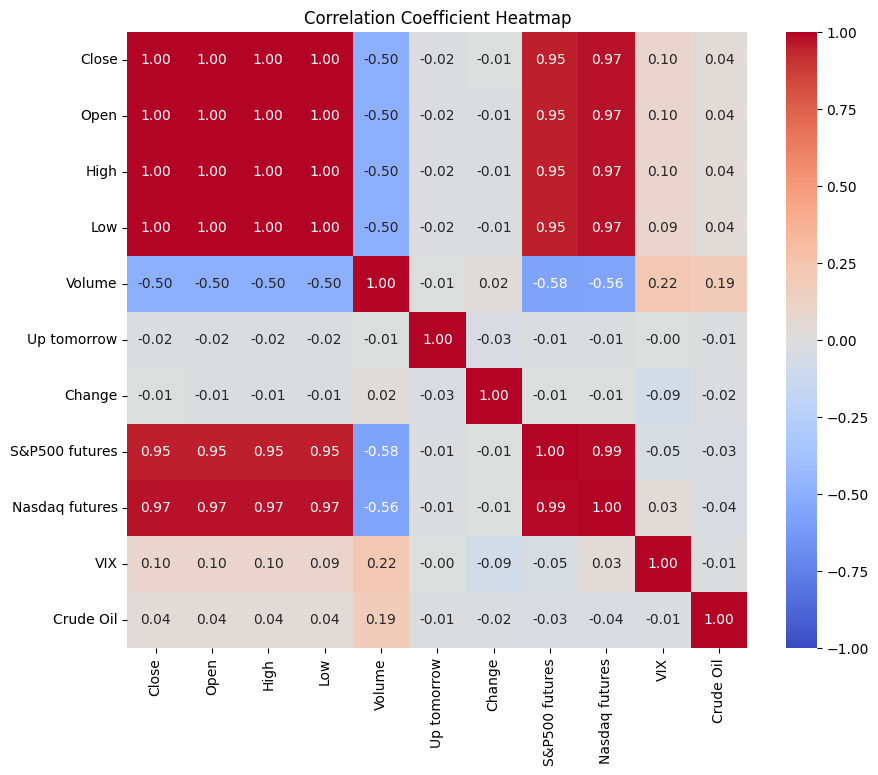

% of highly correlated pairs: 33.1 %


In [398]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,
            cmap='coolwarm',
            vmin=-1, vmax=1,
            fmt='.2f')

# Add a title to the heatmap
plt.title("Correlation Coefficient Heatmap")

# Show the plot
plt.show()

# Find pairs of columns with correlation coefficients >= 0.5 or <= -0.5
high_corr = 0
num_cols = len(df.columns)
for column1 in correlation_matrix.columns:
    for column2 in correlation_matrix.columns:
        if column1 != column2 and abs(correlation_matrix.loc[column1, column2]) >= 0.5:
            high_corr += 1
print(f"% of highly correlated pairs: {high_corr/(num_cols**2)*100:.1f} %")

여러 기업의 주가를 반영하는 "S&P500", "Nasdaq"은 AAPL Price와 Correlation이 높았고 나머지 추가한 feature들은 크지 않았다.

<Axes: >

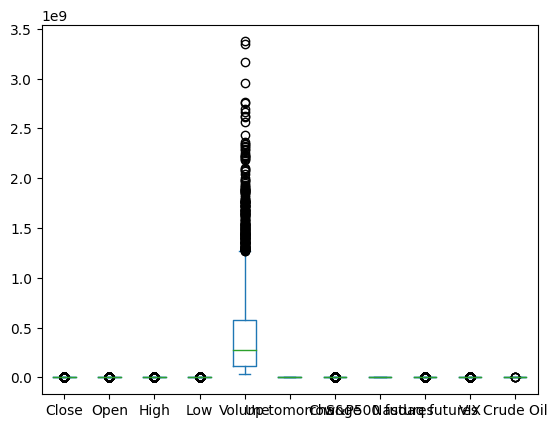

In [399]:
df.plot.box()

Volume의 분포가 다른 column들에 비해 비교적 너무 크기 때문에 학습을 하려면 Scaling이 필요해 보인다.

### KNN

Features = ['Close', 'Open', 'High', 'Low', 'Volume'] 

***************** Neighbors = 5 *******************
MAE:            4.9322956817829064
RMSE:           55.45662769260967
R^2:            0.8380617323449898


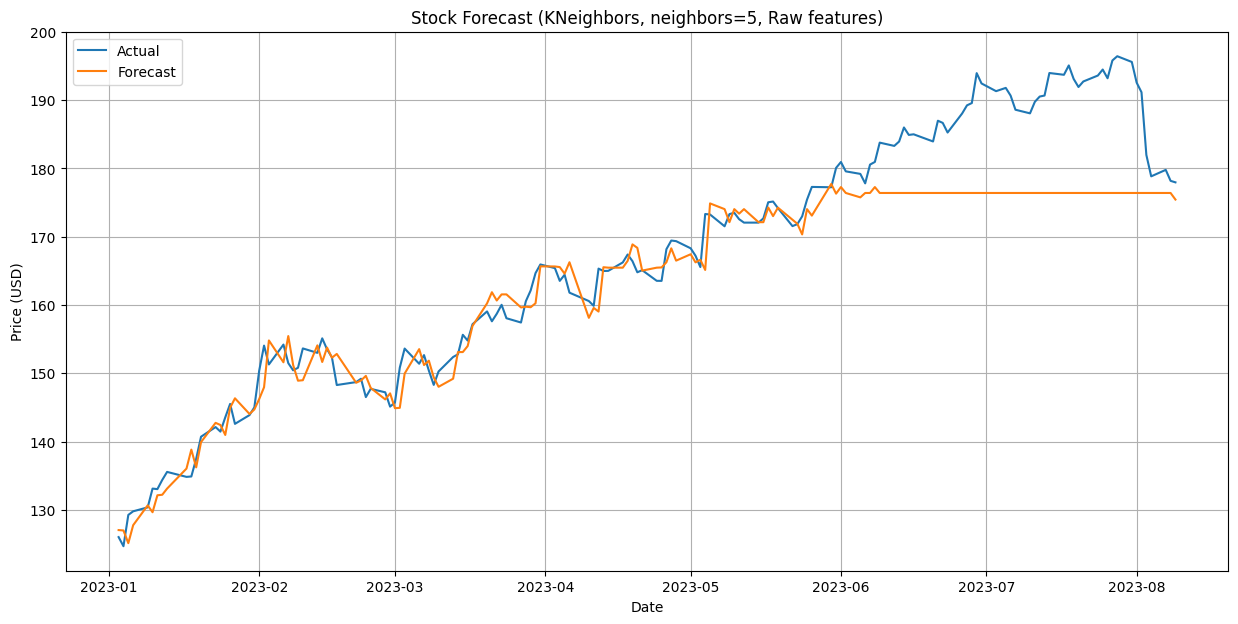

In [400]:
# feature 추가 안한 data

# 원본 데이터에서 입력 변수(X)와 출력 변수(y) 설정
X_raw = df.iloc[:-1, :5]
y = df.iloc[1:, 0]

# 훈련 데이터와 테스트 데이터 분할
X_train_raw = X_raw[X_raw.index.year < 2023].values
X_test_raw = X_raw[X_raw.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')].values
y_test = y[y.index.year == 2023][1:].values

# 테스트 데이터 인덱스 저장
X_test_idx = X_raw[X_raw.index.year == 2023].index

# 스케일링
scaler = MinMaxScaler()
X_train_knn = scaler.fit_transform(X_train_raw)
X_test_knn = scaler.transform(X_test_raw)

# K 최근접 이웃 회귀 모델 훈련
kn = KNeighborsRegressor(n_neighbors=5)
kn.fit(X_train_knn, y_train)

# 모델을 사용하여 예측 수행
yhat = kn.predict(X_test_knn)

# 예측 결과 평가 지표 계산
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = kn.score(X_test_knn, y_test)

# 결과 출력
print(f'Features = {list(X_raw.columns)} \n')
print(f'***************** Neighbors = {5} *******************')
print(f'MAE:            {mae}')
print(f'RMSE:           {mse}')
print(f'R^2:            {R2}')

# 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title("Stock Forecast (KNeighbors, neighbors=5, Raw features)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

예측을 하다가 특정시점부터 포기해버린다, "내일의 종가는 오늘과 같을 거야"라고 예측해버리는 듯한 Forecast값이 오른쪽으로 밀린(후행예측(?))을 하는 듯한 느낌이다

#### Feature engineering

Features = ['Close', 'Open', 'High', 'Low', 'Volume', 'Up tomorrow', 'Change', 'S&P500 futures', 'Nasdaq futures', 'VIX', 'Crude Oil'] 

***************** Neighbors = 5 *******************
MAE:            5.60815598443644
RMSE:           58.88167160741278
R^2:            0.8280603005724001


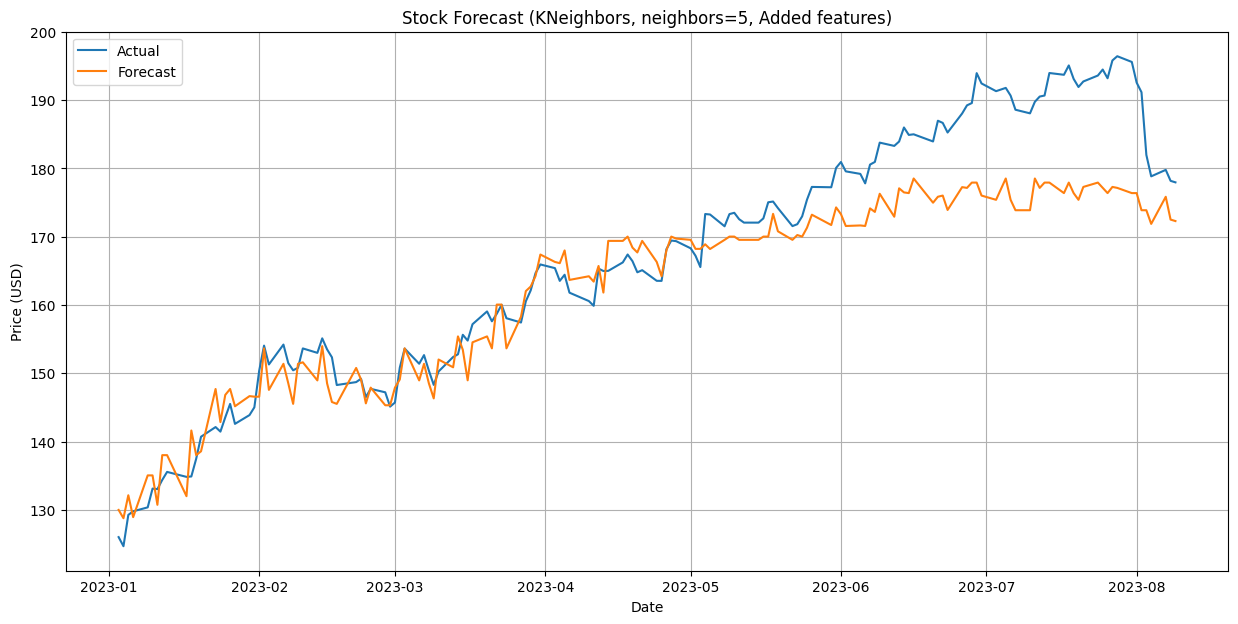

In [401]:
# feature 추가한 data

# 원본 데이터에서 입력 변수(X)와 출력 변수(y) 설정
X = df.iloc[:-1, :]
y = df.iloc[1:, 0]

# 훈련 데이터와 테스트 데이터 분할
X_train = X[X.index.year < 2023].values
X_test = X[X.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')].values
y_test = y[y.index.year == 2023][1:].values

# 테스트 데이터 인덱스 저장
X_test_idx = X[X.index.year == 2023].index

# 스케일링
scaler = MinMaxScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.transform(X_test)

# K 최근접 이웃 회귀 모델 훈련
kn = KNeighborsRegressor(n_neighbors=5)
kn.fit(X_train_, y_train)

# 모델을 사용하여 예측 수행
yhat = kn.predict(X_test_)

# 예측 결과 평가 지표 계산
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = kn.score(X_test_, y_test)

# 결과 출력
print(f'Features = {list(X.columns)} \n')
print(f'***************** Neighbors = {5} *******************')
print(f'MAE:            {mae}')
print(f'RMSE:           {mse}')
print(f'R^2:            {R2}')

# 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title("Stock Forecast (KNeighbors, neighbors=5, Added features)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

feature들을 추가한 결과, 후행예측하는 듯한 느낌이 비교적 사라졌지만, 정확도는 더 떨어졌다; 이전과 같이 특정시점부터 예측을 못한다.

#### Hyperparameter tunning (GridSearchCV)
Model Hyperparameter tunning with features selected above

Features = ['Close', 'Open', 'High', 'Low', 'Volume'] 

Best Parameter: {'n_neighbors': 50} 

***************** Neighbors = 50 *******************
MAE:            5.60815598443644
RMSE:           58.88167160741278
R^2:           0.8280603005724001


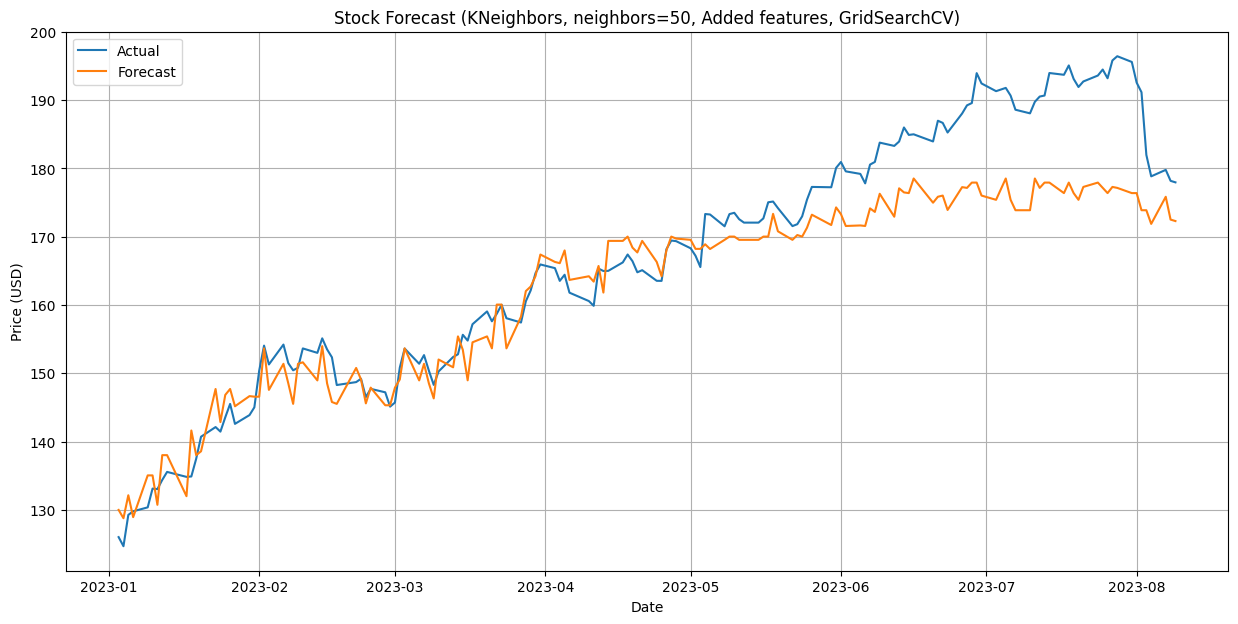

In [402]:
scaler = MinMaxScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.transform(X_test)

params = {"n_neighbors": [i for i in range(2, 101, 2)]}

kn = KNeighborsRegressor()
kn.fit(X_train_, y_train)
grid_cv = GridSearchCV(kn, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train,y_train)

n_neighbors = grid_cv.best_params_['n_neighbors']

yhat = kn.predict(X_test_)
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = kn.score(X_test_, y_test)

print(f'Features = {list(X_raw.columns)} \n')
print(f"Best Parameter: {grid_cv.best_params_} \n")
print(f'***************** Neighbors = {n_neighbors} *******************')
print(f'MAE:            {mae}')
print(f'RMSE:           {mse}')
print(f'R^2:           {R2}')

plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title(f"Stock Forecast (KNeighbors, neighbors={n_neighbors}, Added features, GridSearchCV)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

GridSearchCV를 통해 최적의 하이퍼파라미터값을 찾아 적용시켜주었다. 최적의 값은 n_neighbors=50로 나왔지만 기존 n_neighbors=5와 성능이 비슷해 의미가 없다.

### RandomForest

Features = ['Close', 'Open', 'High', 'Low', 'Volume'] 

MAE:           5.148607306575143
MSE:           61.796604631425865
R^2:           0.8195484378090253


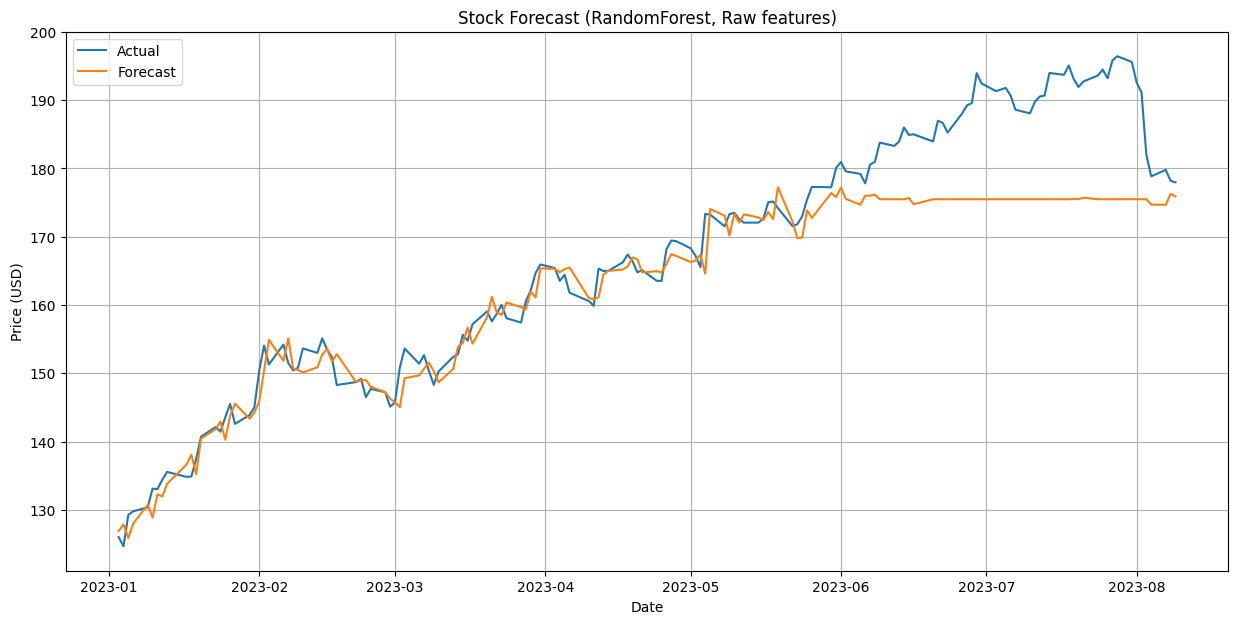

In [403]:
# 원본 데이터에서 입력 변수(X)와 출력 변수(y) 설정
X_raw = df.iloc[:-1, :5]
y = df.iloc[1:, 0]

# 훈련 데이터와 테스트 데이터 분할
X_train_raw = X_raw[X_raw.index.year < 2023].values
X_test_raw = X_raw[X_raw.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')].values
y_test = y[y.index.year == 2023][1:].values

# 테스트 데이터 인덱스 저장
X_test_idx = X_raw[X_raw.index.year == 2023].index

# 랜덤 포레스트 회귀 모델 훈련
rf = RandomForestRegressor(random_state=42, n_jobs=1)
rf.fit(X_train_raw, y_train)

# 모델을 사용하여 예측 수행
yhat = rf.predict(X_test_raw)

# 예측 결과 평가 지표 계산
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = rf.score(X_test_raw, y_test)

# 결과 출력
print(f'Features = {list(X_raw.columns)} \n')
print(f'MAE:           {mae}')
print(f'MSE:           {mse}')
print(f'R^2:           {R2}')

# 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title("Stock Forecast (RandomForest, Raw features)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

KNN 모델을 사용해 예측 할 때보다 비교적 성능이 매우 좋아 보인다, 하지만 후행예측을 하는 느낌이 있다.    특정시점부터 예측을 포기해버리는 모습은 같다.

#### Feature engineering

Columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'Up tomorrow', 'Change', 'S&P500 futures', 'Nasdaq futures', 'VIX', 'Crude Oil'] 

MAE:           4.734446543005129
MSE:           59.558043154886455
R^2:           0.8260852357109709


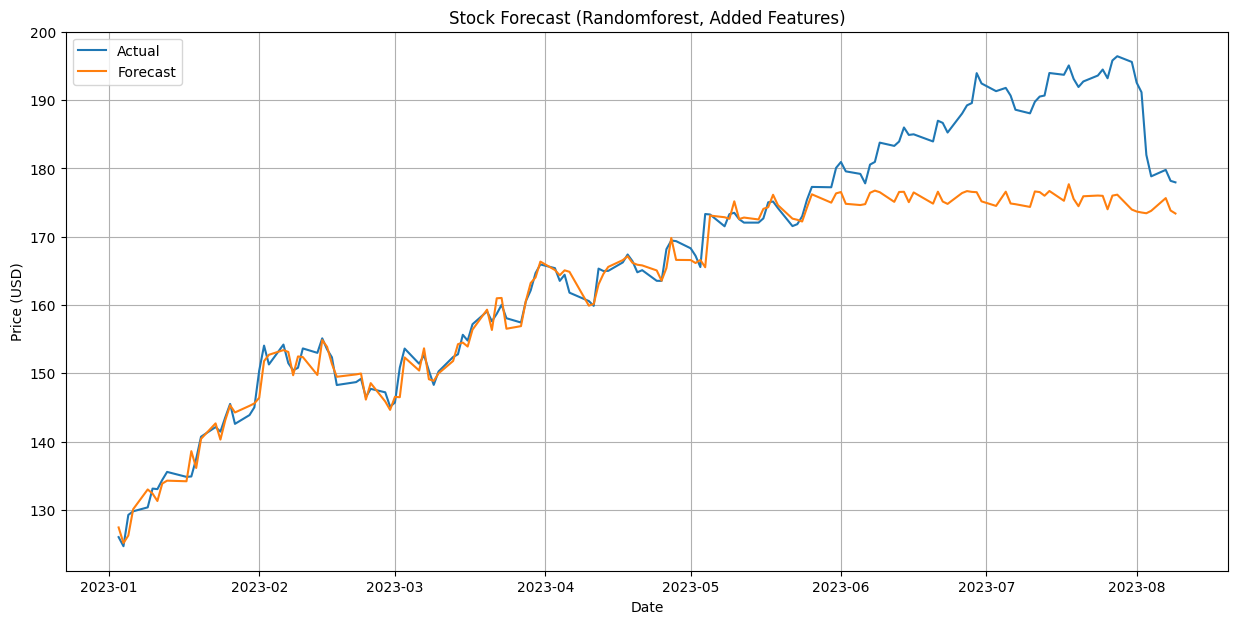

In [404]:
# 원본 데이터에서 입력 변수(X)와 출력 변수(y) 설정
X = df.iloc[:-1, :]
y = df.iloc[1:, 0]

# 훈련 데이터와 테스트 데이터 분할
X_train = X[X.index.year < 2023].values
X_test = X[X.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')].values
y_test = y[y.index.year == 2023][1:].values

# 테스트 데이터 인덱스 저장
X_test_idx = X[X.index.year == 2023].index

# 랜덤 포레스트 회귀 모델 훈련
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 모델을 사용하여 예측 수행
yhat = rf.predict(X_test)

# 예측 결과 평가 지표 계산
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = rf.score(X_test, y_test)

# 결과 출력
print(f'Columns = {list(X.columns)} \n')
print(f'MAE:           {mae}')
print(f'MSE:           {mse}')
print(f'R^2:           {R2}')

# 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title("Stock Forecast (Randomforest, Added Features)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

feature들을 추가한 결과, 매우 정확하게 예측을 한다. 후행예측을 하는 경향도 비교적 사라졌다. 

#### Hyperparameter tunning (GridSearchCV)
Model Hyperparameter tunning with features selected above

Columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'Up tomorrow', 'Change', 'S&P500 futures', 'Nasdaq futures', 'VIX', 'Crude Oil'] 

MAE:           4.884572316403283
MSE:           62.66058576822016
R^2:           0.8170255363200529


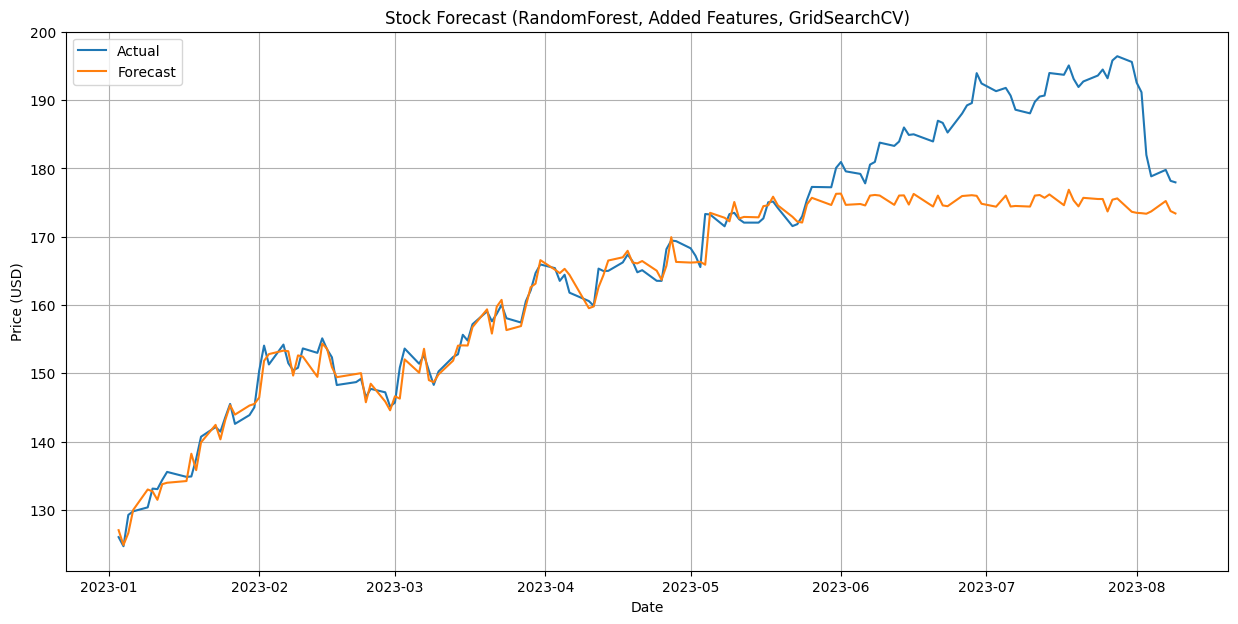

In [405]:
# 원본 데이터에서 입력 변수(X)와 출력 변수(y) 설정
X = df.iloc[:-1, :]
y = df.iloc[1:, 0]

# 훈련 데이터와 테스트 데이터 분할
X_train = X[X.index.year < 2023].values
X_test = X[X.index.year == 2023].values

y_train = y[y.index <= np.datetime64('2023-01-03')].values
y_test = y[y.index.year == 2023][1:].values

# 랜덤 포레스트 모델 훈련 및 그리드 서치로 최적의 하이퍼파라미터 탐색
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 12, 14],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [6, 8, 10],
    "max_features": [1.0, "sqrt", "log2"],
    "bootstrap": [True, False],
}

rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

# 최적의 하이퍼파라미터 저장
max_depth = grid_cv.best_params_['max_depth']
min_samples_leaf = grid_cv.best_params_['min_samples_leaf']
min_samples_split = grid_cv.best_params_['min_samples_split']
n_estimators = grid_cv.best_params_['n_estimators']

# 최적의 하이퍼파라미터로 랜덤 포레스트 모델 훈련
rf = RandomForestRegressor(
    random_state=42, n_estimators=n_estimators, max_depth=max_depth,
    min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split
)
rf.fit(X_train, y_train)

# 모델을 사용하여 예측 수행
yhat = rf.predict(X_test)

# 예측 결과 평가 지표 계산
mae = metrics.mean_absolute_error(y_test, yhat)
mse = metrics.mean_squared_error(y_test, yhat)
R2 = rf.score(X_test, y_test)

# 결과 출력
print(f'Columns = {list(X.columns)} \n')
print(f'MAE:           {mae}')
print(f'MSE:           {mse}')
print(f'R^2:           {R2}')

# 예측 결과 시각화
plt.figure(figsize=(15, 7))
plt.plot(X_test_idx, y_test)
plt.plot(X_test_idx, yhat)
plt.legend(["Actual", "Forecast"])
plt.title("Stock Forecast (RandomForest, Added Features, GridSearchCV)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()

최적의 하이퍼파라미터를 찾기 위해 GridSearchCV를 사용했지만, 오히려 감소한 성능을 보인다.

#### K-fold Cross validation

In [414]:
X = df.iloc[:-1, :]
y = df.iloc[1:, 0]

tscv = TimeSeriesSplit(n_splits=5, test_size=100)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # 랜덤 포레스트 모델 생성 및 훈련
    rf = RandomForestRegressor(
    random_state=42, bootstrap=False, max_depth=14, max_features=1.0,
    min_samples_leaf=4, min_samples_split=10, n_estimators=50
)
    rf.fit(X_train, y_train)

    # 예측값 계산
    y_hat = rf.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, y_hat)
    mse = metrics.mean_squared_error(y_test, y_hat)
    R2 = rf.score(X_test, y_test)


    print(f'Train_score: {rf.score(X_train, y_train)}')
    print(f'Test_score: {rf.score(X_test, y_test)} \n')


print(f'Columns = {list(X.columns)} \n')

Train_score: 0.999817674876384
Test_score: -0.47943691900994123 

Train_score: 0.9998346094800472
Test_score: 0.7949237512023262 

Train_score: 0.9998380409473286
Test_score: 0.9481781211701099 

Train_score: 0.9998540439177758
Test_score: 0.8800422185098394 

Train_score: 0.9998563600719451
Test_score: 0.2622699222651602 

Columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'Up tomorrow', 'Change', 'S&P500 futures', 'Nasdaq futures', 'VIX', 'Crude Oil'] 



시계열을 고려해 Validation data를 나눠주는 TimeSeriesSplit을 사용한 두 결과 모두 비슷하게 나왔다. 초반 Test_Score는 underfitting으로 인해 낮게 나온 것으로 보이고, 특정시점부터 예측을 포기해 마지막 test_score는 낮게 나온 것으로 보인다.

랜덤성이 너무 짙고 외부적인 요인들이 많은 주가를 에측할 때 학습시킨 Data와 근접한 날짜의 예측은 정확도가 높아 보이지만, 점점 정확도가 떨어지다가 예측을 포기해버리는 것으로 보아 단기 예측에 적합해 보이며 장기적인 예측은 어려워 보인다

---

# 선행기술/최신동향

#### 코스피 단기예측 AI 모델_삼성증권 (2019.11.18)

최신동향은 아니지만 내가 구상한 예측 모델과 가장 유사한 보고서 같아 조사해보았다.

* Model: RandomForest

* Feaetures
    - Citi G10 ESI 한국 P/E의 선진국 대비 할인율
    - Citi EM ESI KOSPI Trailing P/B
    - 원/달러 환율 FY2 이익조정비율 (1m)
    - 한국 수출 증가율 FQ1 이익조정비율 (1m)
    - WTI 유가 FQ1 이익조정비율 (1w)
    - US Core PCE 투자의견 점수 변화율 (1w)
    - KOSPI Forward P/E VKOSPI, Yield Gap VIX
    - 한국 P/E의 이머징 대비 할인율 Put-call volume ratio (20d)
    - KOSPI Trailing P/B
    - FY2 이익조정비율 (1m)
    - FQ1 이익조정비율 (1m)
    - FQ1 이익조정비율 (1w)
    - 투자의견 점수 변화율 (1w)
    - VKOSPI
    - VIX
    - Put-call volume ratio (20d)


* Target
    - KOSPI 방향성 (상승/보합/하락)

* Data갯수(기간): 약 4천개(약 4년) 

* Accuracy: 81%